In [1]:
from PIL import Image
from scipy.interpolate import interp1d
from scipy import interpolate
from operator import itemgetter
import collections
import itertools
from scipy.interpolate import CubicSpline




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import math
import cv2
import operator
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
img = Image.open("duck.jpg").convert('1')
black, white = img.getcolors()

print(black[0])
print(white[0])


5584
457360


In [4]:
img_filepath = 'duck6.png'
#im = Image.open(img_filepath,'r')
im = Image.open(img_filepath).convert('RGB')
pix_val = list(im.getdata())
print(pix_val[0])
pix_val_flat = [x for sets in pix_val for x in sets]

def getNumPixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

num = getNumPixels(img_filepath)
print(num)

(255, 255, 255)
462944


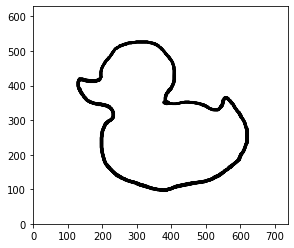

In [5]:
img=mpimg.imread(img_filepath)

fig, ax = plt.subplots()
values = len(img.shape)
if (values == 2):
    height, width = img.shape
else:
    height, width, channels = img.shape
ax.imshow(img, extent=[0, width, 0, height])


In [6]:
#if pixel value within the specific tolerance, then return it as a valid coord
def withinThreshold(pix_value, tol):
    white = (255, 255, 255)
    r = pix_value[0]
    g = pix_value[1]
    b = pix_value[2]
    
    i = tol
    pos_values = [255]
    while i > 0:
        pos_value = white[0] - i
        pos_values.append(pos_value)
        i = i - 1
    return (r in pos_values) & (g in pos_values) & (b in pos_values)

def getCoords():
    coords_x = []
    coords_y = []
    h = height
    w = 0
    i = 0
    first_pix = False
    while i < num:
        if (w >= width):
            h -= 1
            w = 0  
        if (not withinThreshold(pix_val[i], 20)):
            coords_x.append(w)
            coords_y.append(h)
        w += 1
        i += 1
    return coords_x, coords_y

coords_x, coords_y = getCoords()


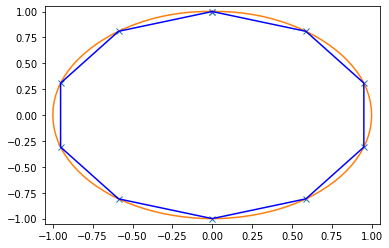

In [7]:
t = np.arange(0, 1.1, .1)
x = np.sin(2*np.pi*t)
y = np.cos(2*np.pi*t)
tck, u = interpolate.splprep([x, y], s=0)
unew = np.arange(0, 1.01, 0.01)
out = interpolate.splev(unew, tck)
plt.figure()
plt.plot(x, y, 'x', out[0], out[1], x, y, 'b')
plt.axis([-1.05, 1.05, -1.05, 1.05])
plt.show()

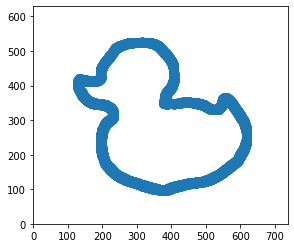

In [8]:
img=mpimg.imread(img_filepath)

fig, ax = plt.subplots()
height, width, channels = img.shape
ax.imshow(img, extent=[0, width, 0, height])
plt.scatter(coords_x, coords_y)

In [9]:
def splitCoord(coord):
    x_coord = [pair[0] for pair in coord]
    y_coord = [pair[1] for pair in coord]
    return x_coord, y_coord

def groupCoord():
    coordinates = []
    for i in range(len(coords_x)):
        pair = (coords_x[i], coords_y[i])
        coordinates.append(pair)
    return coordinates

coord = groupCoord()

def coordSortBy(coord, method):
    if (method == 'x'):
        #sort by increasing x values
        coord_xsorted = sorted(coord, key=lambda x: x[0])
        return coord_xsorted
    if (method == 'y'):
        #sort by increasing y values
        coord_ysorted = sorted(coord, key=lambda x: x[1])
        return coord_ysorted

def coordGroupBy(coord, method):
    if (method == 'x'):
        #sort by increasing x values
        coord_grouped_x = [(key, [val[1] for val in value]) 
                       for key, value in itertools.groupby(coord, lambda x: x[0])]
        return coord_grouped_x
    if (method == 'y'):
        #sort by increasing y values
        coord_grouped_y = [(key, [val[0] for val in value]) 
                       for key, value in itertools.groupby(y_sorted, lambda x: x[1])]
        return coord_grouped_y
    
xvals = coordSortBy(coord, 'x')
splittedx, splittedy = splitCoord(xvals)


In [10]:
def cleanData(coord, method):
    coord_grouped = coordGroupBy(coord, method)
    if (method not in ['x', 'y']):
        print('put valid method')
        return
        
    cleanedCoord = []
    for group in coord_grouped:
        xval = group[0]
        yvals = group[1]
        ylen = len(yvals)
        if (len(yvals) <= 2):
            for i in yvals:
                if (method == 'x'):
                    tup = (xval, i)
                else:
                    tup = (i, xval)
                cleanedCoord.append(tup)
        else:
            maxy = yvals[0]
            stored_i = 0
            nxt = 0
            for i in range(1, ylen):
                miny = yvals[i]
                if (i+1) < ylen:
                    nxt = yvals[i+1]
                    if (abs(miny - nxt) > 20):
                        index = (i + stored_i)//2
                        if (method == 'x'):
                            tup = (xval, yvals[index])
                        else:
                            tup = (yvals[index], xval)
                        cleanedCoord.append(tup)
                        stored_i = i+1
                        maxy = nxt
                    else:
                        next
                else:
                    index = (i+stored_i)//2
                    if (method == 'x'):
                            tup = (xval, yvals[index])
                    else:
                        tup = (yvals[index], xval)
                    cleanedCoord.append(tup)
    return cleanedCoord

x_sorted = coordSortBy(coord, 'x')
cleanedCoord_x = cleanData(x_sorted, 'x')
y_sorted = coordSortBy(cleanedCoord_x, 'y')
cleanedCoord_y = cleanData(y_sorted, 'y')
len(cleanedCoord_y)


496

In [11]:
y_sorted = coordSortBy(coord, 'y')
coord_grouped_y = [(key, [val[0] for val in value]) 
                       for key, value in itertools.groupby(y_sorted, lambda x: x[1])]


In [12]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

def subdivideCoord(splits, returned):
    num_x = collections.Counter([x for (x,y) in splits])
    num_y = collections.Counter([y for (x,y) in splits])    
    divisions_x = num_x.most_common(1)[0][1]
    divisions_y = num_y.most_common(1)[0][1]
    if (divisions_x == 1) and (divisions_y == 1):
        returned.append(splits)  
    else:
        coord_xsorted = sorted(splits, key=lambda x: x[0])
        coord_ysorted = sorted(splits, key=lambda x: x[1])
        if (divisions_y >= divisions_x):
            split1, split2 = split_list(coord_ysorted)
            subdivideCoord(split1, returned)
            subdivideCoord(split2, returned)
        else:
            split1, split2 = split_list(coord_xsorted)
            subdivideCoord(split1, returned)
            subdivideCoord(split2, returned)
    return returned

returned = []
thesplit = coordSortBy(cleanedCoord_y, 'y')
splits = subdivideCoord(thesplit, returned)
len(splits)

309

496

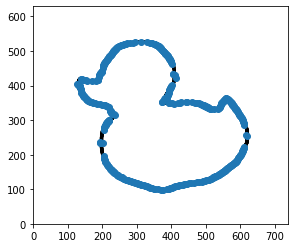

In [13]:
x, y = splitCoord(cleanedCoord_y)

img=mpimg.imread(img_filepath)

fig, ax = plt.subplots()
height, width, channels = img.shape
ax.imshow(img, extent=[0, width, 0, height])


plt.scatter(x, y)

len(x)

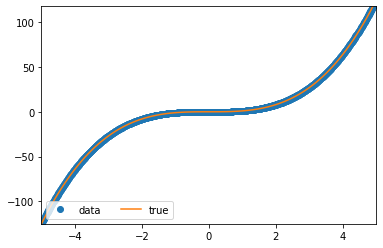

In [14]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
f = lambda y: y**3

def apply(f, x):
    y = []
    for i in x:
        y.append(f(i))
    return y


x = np.arange(-5, 5, 0.01)
y = apply(f, x)
cs = CubicSpline(x, y)
xs = np.arange(-5, 5, 0.1)
ys = cs(xs)
plt.plot(x, y, 'o', label='data')
plt.plot(xs, apply(f, xs), label='true')
#plt.plot(xs, ys, label="S")

plt.xlim(-5, 5)
plt.ylim(min(ys), max(ys))
plt.legend(loc='lower left', ncol=2)
plt.show()

In [15]:
def duplicates(lst, item, method):
    if (method == 'x'):   
        return [i[0] for i in enumerate(lst) if i[1][0] == item]
    elif (method == 'y'):
        return [i[0] for i in enumerate(lst) if i[1][1] == item]
    else:
        print('not a valid method, choose x or y')

def findClosestDup(lst, method):
    sub = []
    for pair in lst:
        sub.append(pair)
        if (method == 'x'):
            indices = duplicates(sub, pair[0], method)
        elif (method == 'y'):
            indices = duplicates(sub, pair[1], method)
        if len(indices) > 1:
            return indices
    return indices

def calculateDist(pair1, pair2):
    p1 = [pair1[0], pair1[1]]
    p2 = [pair2[0], pair2[1]]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    return distance

def subdivideCoord(splits, returned):
    splits = coordSortBy(splits, 'y')
    sub = []
    num_x = collections.Counter([x for (x,y) in splits])
    num_y = collections.Counter([y for (x,y) in splits])
    divisions_x = num_x.most_common(1)[0][1]
    divisions_y = num_y.most_common(1)[0][1]

    if (divisions_x == 1):
        returned.append(splits)
        return returned     
    else:
        indices = findClosestDup(splits, 'x')       
        if (len(indices) == 1):
            index = indices[0]
        else:
            index = indices[1]
        sub = splits[:index]
        returned.append(sub)
        subdivideCoord(splits[index:], returned)
    return returned

def getBottom(splits, returned):
    splits = coordSortBy(splits, 'y')
    sub = []
    num_x = collections.Counter([x for (x,y) in splits])
    num_y = collections.Counter([y for (x,y) in splits])
    divisions_x = num_x.most_common(1)[0][1]
    divisions_y = num_y.most_common(1)[0][1]
    if (divisions_x == 1):
        returned.append(splits)
        return returned            
    else:
        indices_x = findClosestDup(splits, 'x')       
        if (len(indices_x) == 1):
            index = indices_x[0]
        else:
            index = indices_x[1]
        sub = splits[:index]
        sub2 = splits[index:]
        returned.extend([sub, sub2])
    return returned


returned = [] 
thesplit = coordSortBy(cleanedCoord_y, 'y')
#splits = subdivideCoord(thesplit, returned)

bottom = getBottom(thesplit, returned)
#sub = getTrace(bottom[1], returned2)


In [16]:
def twoWorkers(bottom):
    front = bottom[1][0]
    end = bottom[0][-1]
    sub_x = []
    sub_y = []
    subother_x = []
    subother_y = []
    returned = []
    sub_x.append(front[0])
    subother_x.append(end[0])
    sub_y.append(front[1])
    subother_y.append(end[1])
    for i in range(2, len(bottom[1])):
        pair = bottom[1][i]
        pair_x = pair[0]
        pair_y = pair[1]
        if (pair_x in sub_x):
            returned.append([sub_x, sub_y])
            front = pair
            sub_x = [pair_x]
            sub_y = [pair_y]
        if (pair_x in subother_x):
            returned.append([subother_x, subother_y])
            end = pair
            subother_x = [pair_x]
            subother_y = [pair_y]
        else:
            distfront = calculateDist(pair, front)
            distend = calculateDist(pair, end)
            if (distfront < distend):
                sub_x.append(pair_x)
                sub_y.append(pair_y)
                front = pair
            else:
                subother_x.append(pair_x)
                subother_y.append(pair_y)
                end = pair
            if (i+1 == len(bottom[1])):
                sub_x = sub_x + subother_x
                sub_y = sub_y + subother_y
                returned.append([sub_x, sub_y])
                #returned.append([subother_x, subother_y])
    return returned

def makeTuples(lst, bottom):
    combined = []
    for i in range(len(lst)):
        xvals = lst[i][0]
        yvals = lst[i][1]
        sub = []
        for j in range(len(xvals)):
            tup = (xvals[j], yvals[j])
            sub.append(tup)
        combined.append(sub)
    combined.append(bottom)
    return combined

def orderWorkers(lst):

    front = []
    back = []
    returned = []
    for i in range(len(lst)):
        if i%2 == 1:
            returned.append(lst[i])
        else:
            back.append(lst[i])
    back.reverse()
    returned.extend(back)
    return returned
            
    
lst = twoWorkers(bottom)
lst = orderWorkers(lst)
combined = makeTuples(lst, bottom[0])


190
107


(372.5, 312.0)

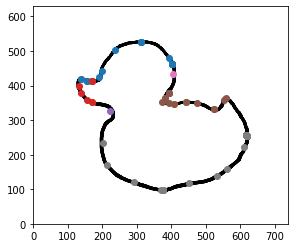

In [17]:
def findCenter(coord):
    xcoords, ycoords = splitCoord(coord)
    max_x = max(xcoords)
    min_x = min(xcoords)
    max_y = max(ycoords)
    min_y = min(ycoords)
    
    mid_x = (max_x + min_x)/2
    mid_y = (max_y + min_y)/2
    return mid_x, mid_y

#find points with biggest rate of change, store in tuple [0] is slope, [1] is index
def findCritPoints(xs, ys, threshold):
    slopes = []
    for i in range(len(xs)):
        if (i+1 < len(xs)):
            x = xs[i]
            next_x = xs[i+1]
            y = ys[i]
            next_y = ys[i+1]
            new_slope = (next_y-y)/(next_x-x)
            new_slope = abs(new_slope)
            if (new_slope >= threshold):
                tup = (new_slope, i)
                slopes.append(tup)    
        else:
            break
    slopes = coordSortBy(slopes, 'x')
    return slopes

def critpoints(xvals, yvals):
    #xvals sorted, yvals not
    critpointsindex = []
    increasing = True
    if (yvals[1] < yvals[0]):
        increasing = False
    for i in range (len(yvals)-1):
        val = yvals[i]
        nextval = yvals[i+1]
        if (increasing and (nextval < val)):
            critpointsindex.append(yvals.index(val))
            increasing = False
        if (increasing == False) and (nextval > val):
            critpointsindex.append(yvals.index(val))
            increasing = True

    return critpointsindex

    
    

def prepForApprox(combined):
    img=mpimg.imread(img_filepath)

    fig, ax = plt.subplots()
    height, width, channels = img.shape
    ax.imshow(img, extent=[0, width, 0, height])
    
    maxim = False
    prevmax = -1 #compare it to next miny
    lencombined = len(combined)
    counter = 1
    order = 0
    orderlist = []
    orderof = []
    
    usedx = []
    usedy = []
    
    for sub in combined:
        sortedSubUniq = list(set(sub))
        sortedSub = coordSortBy(sortedSubUniq, 'x')
        xvals, yvals = splitCoord(sortedSub)
                
        cs = CubicSpline(xvals, yvals)
        cs_firstdiff = cs.derivative(nu=1)
        cs_seconddiff = cs.derivative(nu=2)
        max_der2 = max(abs(cs_seconddiff(xvals)))
        large = np.where(abs(cs_seconddiff(xvals)) > max_der2/2)[0]
        window = 101
        gaps = np.diff(large) > window
        begins = np.insert(large[1:][gaps], 0, large[0])
        ends = np.append(large[:-1][gaps], large[-1])
        changes = ((begins+ends)/2).astype(np.int)
        for i in changes:
            x = xvals[i]
            y = cs(x)
            #plt.scatter(x, y)
        
        
        #ys = cs(xs)
        threshold = 10
        slopes = findCritPoints(xvals, yvals, threshold)
        critpointsindex = critpoints(xvals, yvals)
        
        
        interval = 10
        xs = []
        
        #xs.append(min(xvals))
        #xs.append(max(xvals))
        
        #get endpoints
        maxyindex = yvals.index(max(yvals))
        minyindex = yvals.index(min(yvals))
        if (prevmax == -1) or (counter == lencombined):
            xs.append(xvals[minyindex])
            orderlist.append(order)
            order = order + 1
            prevmax = maxyindex
        if (prevmax != -1) and (abs(minyindex-prevmax) > 100):
            print(abs(minyindex-prevmax))
            xs.append(xvals[minyindex])
            orderlist.append(order)
            order = order + 1
        xs.append(xvals[maxyindex])
        orderlist.append(order)
        order = order + 1
        prevmax = maxyindex

        
        space = len(xvals)/1.5
        #xs.extend(np.arange(min(xvals), max(xvals), space))
        
        maxy = max(yvals)
        miny = min(yvals)
        
        maxx = max(xvals)
        minx = min(xvals)
        
        yrange = maxy-miny
        xrange = maxx-minx
        stepsize = 21
        loopy = yrange//stepsize
        loopx = xrange//stepsize
        
        
        prev = miny + stepsize
        difference = abs(xrange-yrange)
        
        if (yrange < xrange):    
            if (difference > 120):
                prev = minx + stepsize
                xs.append(xvals[xvals.index(min(xvals, key=lambda x:abs(x-560)))])
                orderlist.append(order)
                order = order + 1
                xs.append(xvals[xvals.index(min(xvals, key=lambda x:abs(x-200)))])
                orderlist.append(order)
                order = order + 1
                if (abs(xvals[xvals.index(min(xvals, key=lambda x:abs(x-190)))] - 190) < 3):
                    xs.append(xvals[xvals.index(min(xvals, key=lambda x:abs(x-190)))])
                    print(xvals[xvals.index(min(xvals, key=lambda x:abs(x-190)))])
                    orderlist.append(order)
                    order = order + 1
                stepsize = 80
                for i in range(loopx):
                    if (prev not in xvals):
                        inxvals = False
                        nextclosest = min(xvals, key=lambda x:abs(x-prev))
                        prev = nextclosest
                    
                    xs.append(prev)
                    orderlist.append(order)
                    order = order + 1
                    prev = prev + stepsize
            else:

                for i in range(loopy):
                    if (prev not in yvals):
                        inyvals = False
                        nextclosest = min(yvals, key=lambda x:abs(x-prev))
                        prev = nextclosest

                    yindex = yvals.index(prev)
                    prev = prev + stepsize
                    xs.append(xvals[yindex])
                    orderlist.append(order)
                    order = order + 1

            for index in critpointsindex:
                xval = xvals[index]
                xs.append(xval)
                orderlist.append(order)
                order = order + 1
                plt.scatter(xval, cs(xval))
                
        ys = cs(xs)
        
        
        counter = counter + 1

        #cs_max = max(csdiff(xs))
        #print(csdiff.root())
        
        interval = len(xvals)//10
        plt.xlim(0, width)
        plt.ylim(0, height)
        plt.scatter(xs, ys)
        
        #plt.plot(xvals, dy, 'r--')
        
        #plt.scatter(xvals, yvals)
        usedx.extend(xs)
        usedy.extend(ys)
        orderof.extend(orderlist)
        
        
    return usedx, usedy, orderof
        
usedx, usedy, orderof = prepForApprox(combined)
findCenter(cleanedCoord_y)

[616, 392, 559, 372, 393, 473, 553, 407, 442, 524, 383, 405, 313, 401, 200, 190, 157, 236, 393, 140, 171, 156, 140, 134, 170, 222, 377, 560, 201, 214, 293, 371, 451, 532, 611, 619]
[256, 378, 363, 351, 350, 349, 359, 347, 353, 331, 364, 433, 526, 462, 443, 426, 414, 503, 480, 418, 413, 359, 379, 400, 351, 327, 98, 159, 233, 170, 120, 99, 117, 139, 223, 255]
36
36


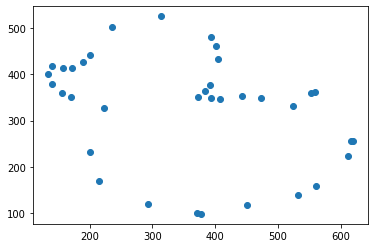

In [18]:


finalx = []
finaly = []
combinedxy = []
for i in range(len(usedx)):
    numx = int(usedx[i])
    numy = int(usedy[i])
    combinedit = (numx, numy)
    if (combinedit not in combinedxy):
        combinedxy.append(combinedit)

finalx, finaly = splitCoord(combinedxy)
print(finalx)
print(finaly)

print(len(finalx))
print(len(finaly))

plt.scatter(finalx, finaly)

In [19]:
def findorder(xvals, yvals):
    order = [0]
    combined = []
    coordinates = []
    indices = []
    for i in range(len(xvals)):
        pair = (xvals[i], yvals[i])
        combined.append(pair)
        coordinates.append(pair)
        indices.append(i)    
    count = len(xvals) - 1
    location = len(xvals)
    closest = float(inf)
    xval0 = combined[0][0]
    yval0 = combined[0][1]
    savedpair = combined[0]
    combined.remove(combined[0])
    while (len(combined) != 0):
        for pair in combined:
            xval1 = pair[0]
            yval1 = pair[1]
            if (xval1 == xval0) and (yval1 == yval0):
                continue
            
            dist = math.sqrt((xval0 - xval1)**2 + (yval0 - yval1)**2)
            if (dist < closest):
                location = coordinates.index(pair)
                closest = dist
                savedpair = pair

        order.append(location)
        combined.remove(savedpair)
        indices.remove(location)
        xval0 = xvals[location]
        yval0 = yvals[location]
        closest = float(inf)
                    
    return order

    
order = findorder(finalx, finaly)
print(order)
print(len(order))
print(len(finalx))

[0, 35, 34, 27, 33, 32, 26, 31, 30, 29, 28, 25, 24, 21, 22, 23, 19, 16, 20, 15, 14, 17, 12, 18, 13, 11, 1, 10, 3, 4, 7, 8, 5, 9, 6, 2]
36
36


In [20]:
def findSubIndex(subdivided, pair, maxy, cur):
    for i in range(maxy):
        xval = pair[0]
        yval = pair[1]
        index = (i + cur)%maxy
        xvals, yvals = splitCoord(subdivided[index])
        if (xval in xvals) or (yval in yvals):
            next
        else:
            return index

def subdivideCoord(splits):
    num_x = collections.Counter([x for (x,y) in splits])
    num_y = collections.Counter([y for (x,y) in splits])
    divisions_x = num_x.most_common(1)[0][1]
    divisions_y = num_y.most_common(1)[0][1]
    if (divisions_x >= divisions_y):
        method = 'x'
    else:
        method = 'y'
    splits_sorted = coordSortBy(splits, method)
    maxy = max([divisions_x, divisions_y])
    subdivided = [[] for x in range(maxy)]
    for i in range(len(splits_sorted)):
        sub_index = i%maxy
        sub = subdivided[sub_index]
        pair = splits_sorted[i]
        sub_index = findSubIndex(subdivided, pair, maxy, sub_index)
        subdivided[sub_index].append(pair)
    return subdivided
    

#splits = cleanedCoord_y
#splits = subdivideCoord(splits)
